# NBN Package

This notebook summarises the data available via the `rnbn` package. The vignette provided with the package provides a better overview of the package --- this notebook just demonstrates what needs to be done to get started with it.

## Setup

`rnbn` is straight forward to get; we just need to install it from CRAN.

In [15]:
library(ggplot2)
library(ggmap)
library(dplyr)
install.packages('rnbn')
library(rnbn)

Warning message:
: package ‘ggplot2’ was built under R version 3.2.3Warning message:
: package ‘ggmap’ was built under R version 3.2.3
Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




The downloaded binary packages are in
	/var/folders/y_/wsxrd3b16k99k229_7f38sph0000gn/T//RtmpX3ipxz/downloaded_packages


## Logging In

The NBN data service needs a username and password. The vignette contains instructions on how to get one. It's not strictly necessary to run `nbnLogin`; all the functions in the package will call `nbnLogin` automatically if you aren't already logged in.

In this case I'm hiding my details in my environment to stop them getting printed out to the console.

In [3]:
#Change these if running.
nbn.user <- Sys.getenv("NBN_USER")
nbn.password <- Sys.getenv("NBN_PASSWORD")

nbnLogin(nbn.user,nbn.password)

## Data Organisation

The NBN set is principally designed to log observations of species in different locations at different times. This is an abstraction over the underlying data generated from studies and data sets.

Data are principally organised by TVKs (Taxon Version Keys). A Taxon is simply a thing that can have observations logged about it. The package includes a function to get the TVKs for names of species to make the mapping easier.

This shows one of several views of the NBN data we can access; the taxon-level information which includes more details on the species and some aggregate stats.

In [4]:
head(getTVKQuery(query="badger"))

entityType searchMatchTitle
1      taxon           Badger
2      taxon      Badger Flea
3      taxon    a Badger flea
4      taxon  Eurasian Badger
                                                                                      descript
1                            Meles meles (Linnaeus, 1758), TERRESTRIAL MAMMAL, 62006 record(s)
2                  Paraceras melis (Walker, 1856), INSECT - FLEA (SIPHONAPTERA), 472 record(s)
3 Chaetopsylla (Chaetopsylla) trichosa Kohaut, 1903, INSECT - FLEA (SIPHONAPTERA), 2 record(s)
4                            Meles meles (Linnaeus, 1758), TERRESTRIAL MAMMAL, 62006 record(s)
                                                                    pExtendedName
1                                Meles meles (Linnaeus, 1758), TERRESTRIAL MAMMAL
2                    Paraceras melis (Walker, 1856), INSECT - FLEA (SIPHONAPTERA)
3 Chaetopsylla (Chaetopsylla) trichosa Kohaut, 1903, INSECT - FLEA (SIPHONAPTERA)
4                                Meles meles (Linnaeus, 1758), TERRESTRIAL MAMMAL
   taxonVersionKey            name languageKey taxonOutputGroupKey
1 NBNSYS0000164968          Badger          en    NHMSYS0000080085
2 NBNSYS0000164969     Badger Flea          en    NHMSYS0000629161
3 NHMSYS0020322599   a Badger flea          en    NHMSYS0000629161
4 NHMSYS0000332260 Eurasian Badger          en    NHMSYS0000080085
          taxonOutputGroupName      organismKey    rank  nameStatus versionForm
1           terrestrial mammal NBNORG0000049711 Species     Synonym Well-formed
2 insect - flea (Siphonaptera) NBNORG0000013049 Species Recommended Well-formed
3 insect - flea (Siphonaptera) NBNORG0000061712 Species Recommended Well-formed
4           terrestrial mammal NBNORG0000049711 Species Recommended Well-formed
  gatewayRecordCount                                          href
1              62006 https://data.nbn.org.uk/Taxa/NHMSYS0000080191
2                472 https://data.nbn.org.uk/Taxa/NBNSYS0000013055
3                  2 https://data.nbn.org.uk/Taxa/NHMSYS0000545919
4              62006 https://data.nbn.org.uk/Taxa/NHMSYS0000080191
  ptaxonVersionKey
1 NHMSYS0000080191
2 NBNSYS0000013055
3 NHMSYS0000545919
4 NHMSYS0000080191

Lists are OK, but usually we just want the top result:

In [5]:
getTVKQuery(query="badger", top=T)

entityType searchMatchTitle
1      taxon           Badger
                                                           descript
1 Meles meles (Linnaeus, 1758), TERRESTRIAL MAMMAL, 62006 record(s)
                                     pExtendedName  taxonVersionKey   name
1 Meles meles (Linnaeus, 1758), TERRESTRIAL MAMMAL NBNSYS0000164968 Badger
  languageKey taxonOutputGroupKey taxonOutputGroupName      organismKey    rank
1          en    NHMSYS0000080085   terrestrial mammal NBNORG0000049711 Species
  nameStatus versionForm gatewayRecordCount
1    Synonym Well-formed              62006
                                           href ptaxonVersionKey
1 https://data.nbn.org.uk/Taxa/NHMSYS0000080191 NHMSYS0000080191

Armed with a Taxon Version Key, you can then interrogate the NBN database for observations of that species.

In [6]:
mushroom <- getTVKQuery(query="mushroom", top=T)
occurrences <- getOccurrences(gridRef='SK38',silent=T,acceptTandC=T)
nrow(occurrences)

[1] 149701

We can plot this a little nicer using ggmap. Before we do, we need densities (there is a lot of overlap between points). We'll make a 10x10 grid and count the observations in each grid. To start with, compute the centres of each grid rectangle:

In [7]:
bins <- 10
x <- seq(from=min(occurrences$longitude), to=max(occurrences$longitude), length.out=bins)
y <- seq(from=min(occurrences$latitude), to=max(occurrences$latitude), length.out=bins)
binwidth.x <- (max(occurrences$longitude) - min(occurrences$longitude) ) / bins
binwidth.y <- (max(occurrences$latitude) - min(occurrences$latitude) ) / bins
binwidth <- c(binwidth.x, binwidth.y)
grid <- expand.grid(x=x,y=y)
head(grid)

x      y
1 -1.5501 53.316
2 -1.5335 53.316
3 -1.5170 53.316
4 -1.5004 53.316
5 -1.4838 53.316
6 -1.4672 53.316

Functions to give us the upper and lower bound of a bin given its centre-point:

In [8]:
bin.centre <- function(coord,d){ binwidth * floor(coord/binwidth[d]) }
bin.lower  <- function(coord,d){ coord - binwidth[d]/2   }
bin.upper  <- function(coord,d){ coord + binwidth[d]/2   }
bin.lower(x,1)

[1] -1.5576 -1.5410 -1.5244 -1.5078 -1.4913 -1.4747 -1.4581 -1.4415 -1.4250
[10] -1.4084

Perform the count for each square. We do this by subsetting occurrences by each region and taking the size of it (using `sum` on the logical is faster than actually subsetting and calling `length`).

In [16]:
density <- mapply(function(x,y){
        with(occurrences,
             list(x=x,y=y,z=sum(
                    longitude > bin.lower(x,1) &
                    longitude <= bin.upper(x,1) & 
                    latitude > bin.lower(y,2) & 
                    latitude  <= bin.upper(y,2))
            ))}, x=grid$x,y=grid$y) %>% t



In [17]:
density <- as.data.frame(cbind(grid, z=unlist(density[,3])))

# density <- within(density, {
#     lx = bin.lower(x)
#     ly = bin.lower(y)
#     ux = bin.upper(x)
#     uy = bin.upper(y)
#     }
#     )
head(density)

x      y   z
1 -1.5501 53.316  71
2 -1.5335 53.316 151
3 -1.5170 53.316 198
4 -1.5004 53.316 111
5 -1.4838 53.316   1
6 -1.4672 53.316   6

How does that look?

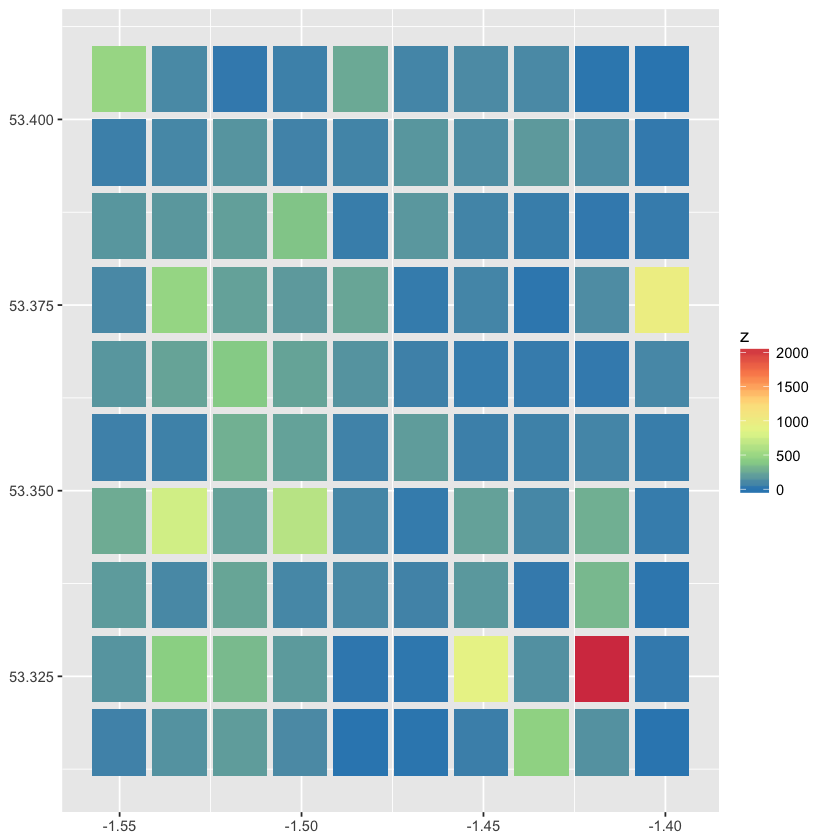

In [18]:
ggplot(density, aes(fill=z)) + 
    geom_rect(aes(xmin=bin.lower(x,1),ymin=bin.lower(y,2),xmax=bin.upper(x,1),ymax=bin.upper(y,2))) +
    scale_fill_distiller(palette = "Spectral")

Now we have our counts for each rectangle, we can plot them over a map. We'll use `ggmap` for this:

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=53.360781,-1.475524&zoom=12&size=640x640&scale=2&maptype=terrain&language=en-EN&sensor=false


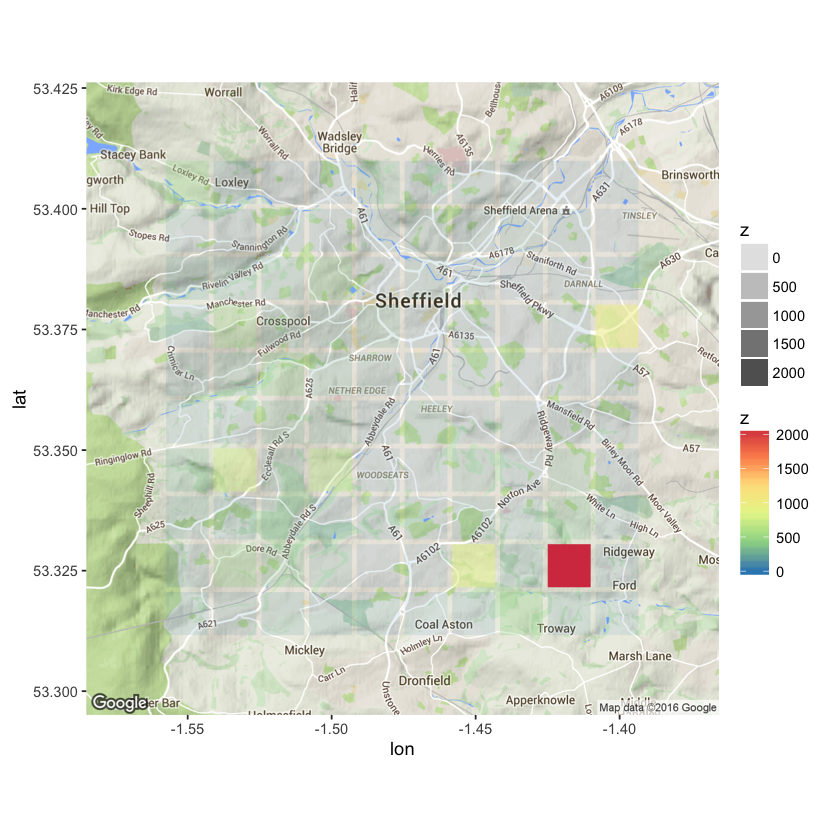

In [19]:
location <- c(median(x),median(y))
map <- get_map(location, zoom=12, source="google")

ggmap(map) + 
    geom_rect(data=density,
              inherit.aes=F,
              aes(xmin=bin.lower(x,1),ymin=bin.lower(y,2),xmax=bin.upper(x,1),ymax=bin.upper(y,2),fill=z,alpha=z)) +
    scale_fill_distiller(palette = "Spectral")


We can also use the grids we computed to visualise the distribution of mushrooms across grid squares. As it turns out, they're (roughly) log-normal so taking logs might make our visualisation look nicer.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
: Removed 1 rows containing non-finite values (stat_bin).

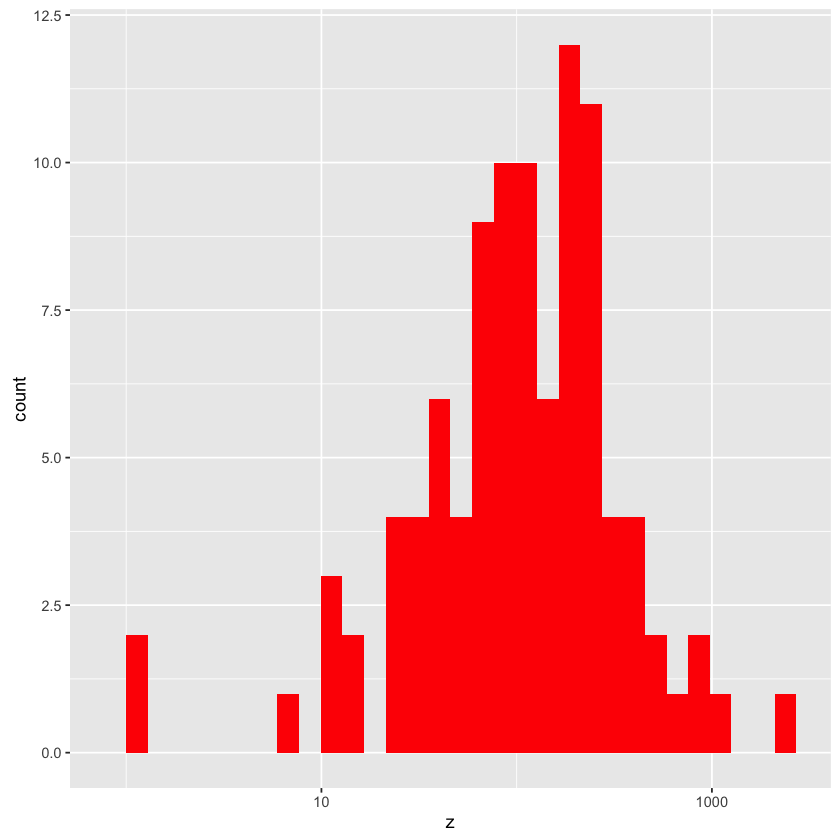

In [20]:
ggplot(density, aes(z))+ geom_histogram(fill='red') + scale_x_log10()

Taking logs, we can see the distribution of mushroom observations more clearly.

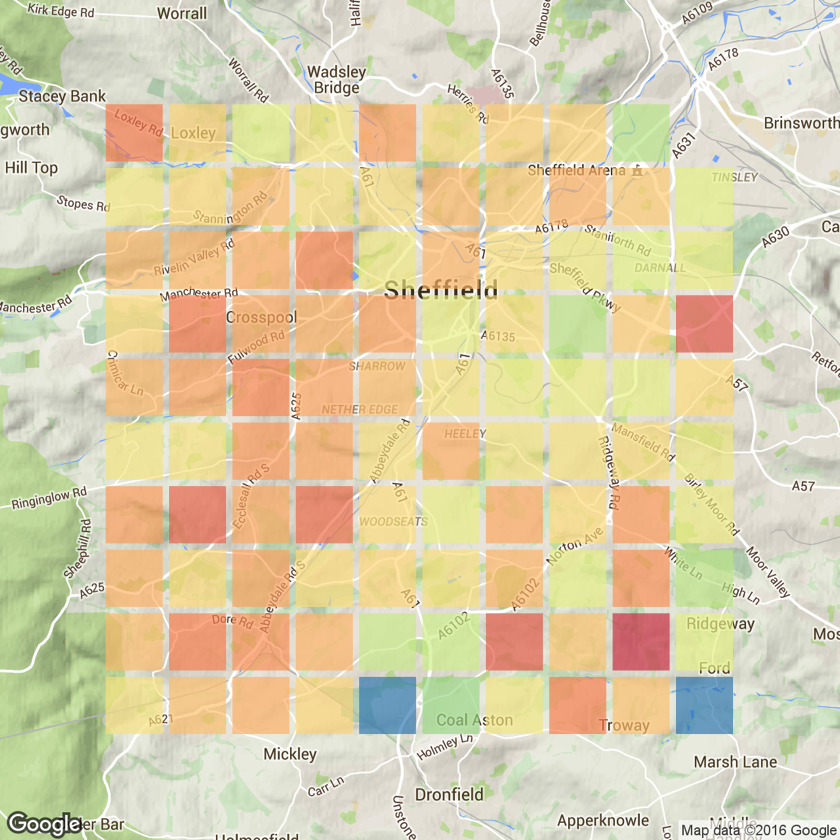

In [26]:

ggmap(map) + 
    geom_rect(data=density[density$z > 0,],
              inherit.aes=F,
              aes(xmin=bin.lower(x,1),ymin=bin.lower(y,2),xmax=bin.upper(x,1),ymax=bin.upper(y,2),fill=z),alpha=0.666)  +
    scale_fill_distiller(palette = "Spectral",trans = "log") + theme_nothing()
ggsave(file="map.png", width=7,height=7, dpi = 109)

No documentation for ‘theme_nothing’ in specified packages and libraries:
you could try ‘??theme_nothing’